In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random

Using TensorFlow backend.


# Collecting Data

In [2]:
import os
#datadir = ""
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv('driving_log.csv',names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,G:\IMG\center_2020_04_17_18_08_33_655.jpg,G:\IMG\left_2020_04_17_18_08_33_655.jpg,G:\IMG\right_2020_04_17_18_08_33_655.jpg,0.0,0.000000,0.0,0.000080
1,G:\IMG\center_2020_04_17_18_08_34_129.jpg,G:\IMG\left_2020_04_17_18_08_34_129.jpg,G:\IMG\right_2020_04_17_18_08_34_129.jpg,0.0,0.000000,0.0,0.000078
2,G:\IMG\center_2020_04_17_18_08_34_292.jpg,G:\IMG\left_2020_04_17_18_08_34_292.jpg,G:\IMG\right_2020_04_17_18_08_34_292.jpg,0.0,0.000000,0.0,0.000080
3,G:\IMG\center_2020_04_17_18_08_34_446.jpg,G:\IMG\left_2020_04_17_18_08_34_446.jpg,G:\IMG\right_2020_04_17_18_08_34_446.jpg,0.0,0.000000,0.0,0.000081
4,G:\IMG\center_2020_04_17_18_08_34_640.jpg,G:\IMG\left_2020_04_17_18_08_34_640.jpg,G:\IMG\right_2020_04_17_18_08_34_640.jpg,0.0,0.558679,0.0,1.130179


In [3]:
import ntpath

In [4]:
def path_leaf(path):
    head,tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_04_17_18_08_33_655.jpg,left_2020_04_17_18_08_33_655.jpg,right_2020_04_17_18_08_33_655.jpg,0.0,0.000000,0.0,0.000080
1,center_2020_04_17_18_08_34_129.jpg,left_2020_04_17_18_08_34_129.jpg,right_2020_04_17_18_08_34_129.jpg,0.0,0.000000,0.0,0.000078
2,center_2020_04_17_18_08_34_292.jpg,left_2020_04_17_18_08_34_292.jpg,right_2020_04_17_18_08_34_292.jpg,0.0,0.000000,0.0,0.000080
3,center_2020_04_17_18_08_34_446.jpg,left_2020_04_17_18_08_34_446.jpg,right_2020_04_17_18_08_34_446.jpg,0.0,0.000000,0.0,0.000081
4,center_2020_04_17_18_08_34_640.jpg,left_2020_04_17_18_08_34_640.jpg,right_2020_04_17_18_08_34_640.jpg,0.0,0.558679,0.0,1.130179


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


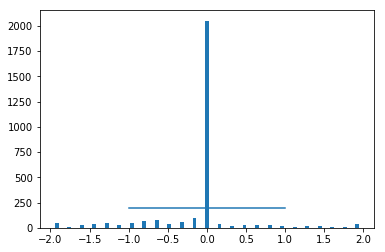

In [5]:
#Show the steering infomation
#画出了清理之后的图，原本应该在下个框里面写完代码再执行
num_bins = 25
samples_per_bin = 200
hist,bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:]) 
#center = (bins[:-1]+bins[1:])+0.5 
print(bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total_data: 2866
removed_data: 1851
remaining: 1015


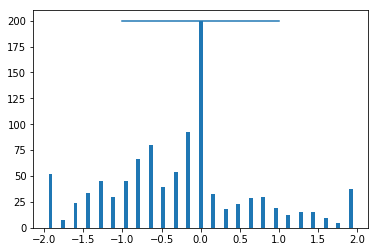

In [6]:
#Remanage the data.
from sklearn.utils import shuffle
print('total_data:',len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i]>= bins[j] and data['steering'][i]<= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)    
print('removed_data:',len(remove_list)) 
data.drop(data.index[remove_list],inplace=True)
print('remaining:',len(data))

hist, _ = np.histogram(data['steering'],(num_bins))
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

# Training & Validation Split

In [7]:
from sklearn.model_selection import train_test_split
print(data.iloc[1])
def load_img_steering(datadir,df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
        image_path.append(os.path.join(datadir,center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths,steerings

image_paths,steerings = load_img_steering('IMG/',data)

center      center_2020_04_17_18_08_34_745.jpg
left        left_2020_04_17_18_08_34_745.jpg  
right       right_2020_04_17_18_08_34_745.jpg 
steering    0                                 
throttle    0.907817                          
reverse     0                                 
speed       2.31446                           
Name: 5, dtype: object


In [8]:
x_train,x_valid, y_train, y_valid = train_test_split(image_paths,steerings,test_size=0.2,random_state=6)
print('Training samples: {}\nValid samples: {}'.format(len(x_train),len(x_valid)))

Training samples: 812
Valid samples: 203


Text(0.5, 1.0, 'Validating Set')

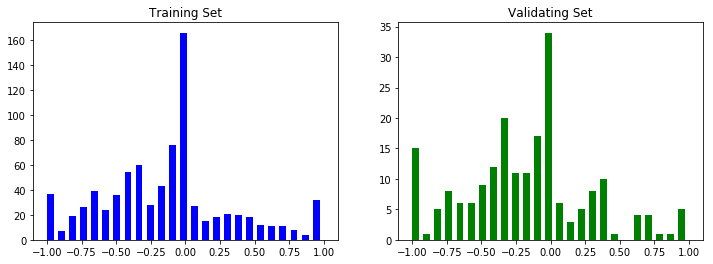

In [9]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins = num_bins, width=0.05, color = 'blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid,bins = num_bins, width=0.05, color = 'green')
axes[1].set_title('Validating Set')

In [10]:
print(image_paths.shape)

(1015,)


In [11]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.image as mpimg
datagen_try = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

x_path = image_paths[random.randint(0,600)]
ox = mpimg.imread(x_path)

# x = img_to_array(img)  # 把PIL图像转换成一个numpy数组，形状为(3, 150, 150)
x = ox.reshape((1,) + ox.shape)  # 这是一个numpy数组，形状为 (1, 3, 150, 150)
print(x.shape)
new_x = datagen_try.flow(x,shuffle=True, batch_size=1, seed=None)
#print(new_x)
new_x_x = next(new_x)
#print(new_x_x)
print(new_x_x.shape)

(1, 160, 320, 3)
(1, 160, 320, 3)


In [12]:
#Transfer the four dimension to three dimension.
#new_x_x = new_x_x.reshape(new_x_x.shape-(1,))
print(new_x_x.shape)
new_x_x = new_x_x.reshape(ox.shape)
print(new_x_x.shape)
#print(new_x_x)

(1, 160, 320, 3)
(160, 320, 3)


In [28]:
# This code can be used to see the augmented images.
# 生产的所有图片保存在 `Preview/` 目录下
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='Preview', save_prefix='imgaug', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # 否则生成器会退出循环

# Data Preprocessing -- Images

In [13]:
import matplotlib.image as mpimg
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135,:,:] #处理最终应有合适feature的preprocesses image.
    img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,(3,3),0) #Make the image much more smooth
    img = cv2.resize(img,(200,66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

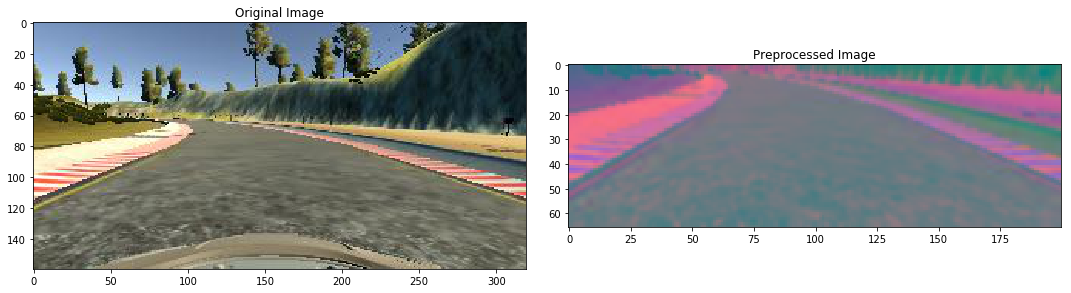

In [14]:
image = image_paths[6]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [15]:
x_train = np.array(list(map(img_preprocess,x_train)))
x_valid = np.array(list(map(img_preprocess,x_valid)))

(812, 66, 200, 3)


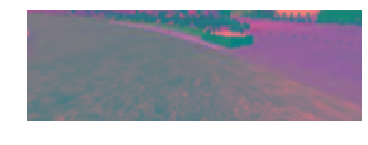

In [16]:
plt.imshow(x_train[random.randint(0,len(x_train)-1)])
plt.axis('off')
print(x_train.shape)

(66, 200, 3)
(66, 200, 3)
[[[-1.68627448e-01  4.36074800e-02 -3.96858781e-02]
  [-2.49995140e-01  5.14026353e-02 -4.32779520e-02]
  [-2.09164080e-01  6.21789763e-02 -4.68700855e-02]
  ...
  [ 2.07843142e-01  4.31372562e-02 -1.17646764e-02]
  [ 2.27450985e-01  4.31372562e-02 -1.17646764e-02]
  [ 2.23529417e-01  4.31372562e-02 -1.17646764e-02]]

 [[-1.74546757e-01  4.95190394e-02 -4.31372257e-02]
  [-2.35294115e-01  5.70327415e-02 -4.52679725e-02]
  [-2.14841824e-01  6.42274692e-02 -4.88601060e-02]
  ...
  [ 1.96078436e-01  4.31372562e-02 -1.17646764e-02]
  [ 2.23529417e-01  4.31372562e-02 -1.17646764e-02]
  [ 2.31372554e-01  4.31372562e-02 -1.56862451e-02]]

 [[-2.02114667e-01  5.93521971e-02 -5.88235002e-02]
  [-2.35294115e-01  6.68658695e-02 -5.90226989e-02]
  [-2.35294115e-01  7.04580030e-02 -6.26148324e-02]
  ...
  [ 1.88235299e-01  4.70588248e-02 -1.17646764e-02]
  [ 2.23529417e-01  4.31372562e-02 -1.17646764e-02]
  [ 2.39215691e-01  4.31372562e-02 -1.17646764e-02]]

 ...

 [[ 1.49

Text(0.5, 1.0, 'Augmented Image')

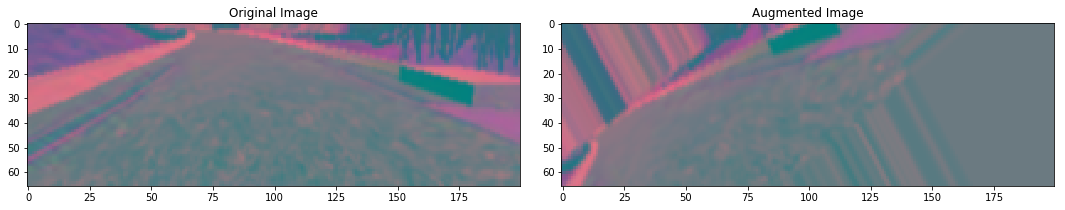

In [17]:
#Show the augmented preprocessed image. 
ox_train = x_train[10]
print(ox_train.shape)
ox_train_x = ox_train.reshape((1,)+ox_train.shape)
datagen = ImageDataGenerator(
        rotation_range=60,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')
new_x_train = datagen.flow(ox_train_x,shuffle=True, batch_size=1, seed=None)
#print(new_x_train)
new_x_x_train = next(new_x_train)
#print(new_x_x_train)
new_x_x_train = new_x_x_train.reshape(ox_train.shape)
print(new_x_x_train.shape)

print(new_x_x_train-ox_train)
fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(ox_train)
axs[0].set_title('Original Image')
axs[1].imshow(new_x_x_train)
axs[1].set_title('Augmented Image')

In [19]:
def random_augment(image,steering_angle):
    #image = mpimg.imread(image)
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')
    image_x = image.reshape((1,) + image.shape)
    image_gen = datagen.flow(image_x,shuffle=True, batch_size=1, seed=None)
    new_image = next(image_gen)
    new_image = new_image.reshape(image.shape) #4维转变为3维，进行图像可视化
    #print(new_image.shape)
    #print(new_image-image)
    return new_image, steering_angle

[[[ 3.46612775e-01  7.56875076e-02 -3.97250998e-02]
  [ 3.28687691e-01  7.56177406e-02 -4.19115174e-02]
  [ 3.15617226e-01  7.61935810e-02 -4.40979350e-02]
  ...
  [-5.49019404e-02 -3.92155729e-03  3.92159294e-03]
  [-3.52940973e-02  1.13365697e-08  2.43093453e-08]
  [ 2.03357023e-08  1.13365697e-08  2.43093453e-08]]

 [[ 3.46496307e-01  9.52095489e-02 -5.31595102e-02]
  [ 3.35704110e-01  9.23161010e-02 -5.22804012e-02]
  [ 3.19174490e-01  9.56903798e-02 -5.25077930e-02]
  ...
  [-3.92154829e-03  1.13365697e-08  2.43093453e-08]
  [ 1.17647262e-02  1.13365697e-08  2.43093453e-08]
  [ 3.13725694e-02  3.92157996e-03 -3.92154432e-03]]

 [[ 3.31100128e-01  1.08071814e-01 -6.18790143e-02]
  [ 3.23780737e-01  1.05109434e-01 -6.10356085e-02]
  [ 3.18059763e-01  1.03265027e-01 -5.97142332e-02]
  ...
  [ 8.23529615e-02 -3.92155729e-03  2.43093453e-08]
  [ 8.23529615e-02  1.13365697e-08  2.43093453e-08]
  [ 7.05882556e-02  3.92157996e-03  2.43093453e-08]]

 ...

 [[ 3.50137671e-02  1.28559036e-09

Text(0.5, 1.0, 'Augmented Image')

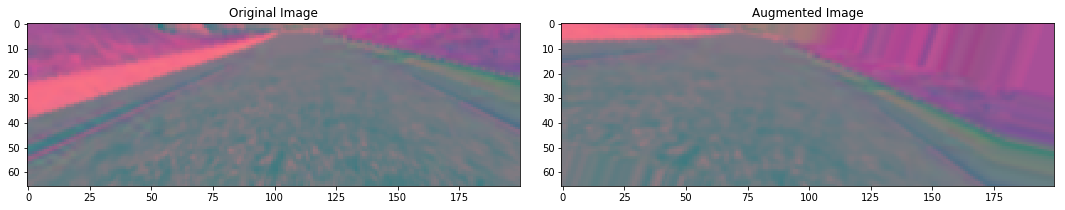

In [20]:
image,steering_angle = random_augment(x_train[100],y_train[100])
print(image-x_train[100])
fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(x_train[100])
axs[0].set_title('Original Image')
axs[1].imshow(image)
axs[1].set_title('Augmented Image')

In [21]:
print(y_train.shape)

(812,)


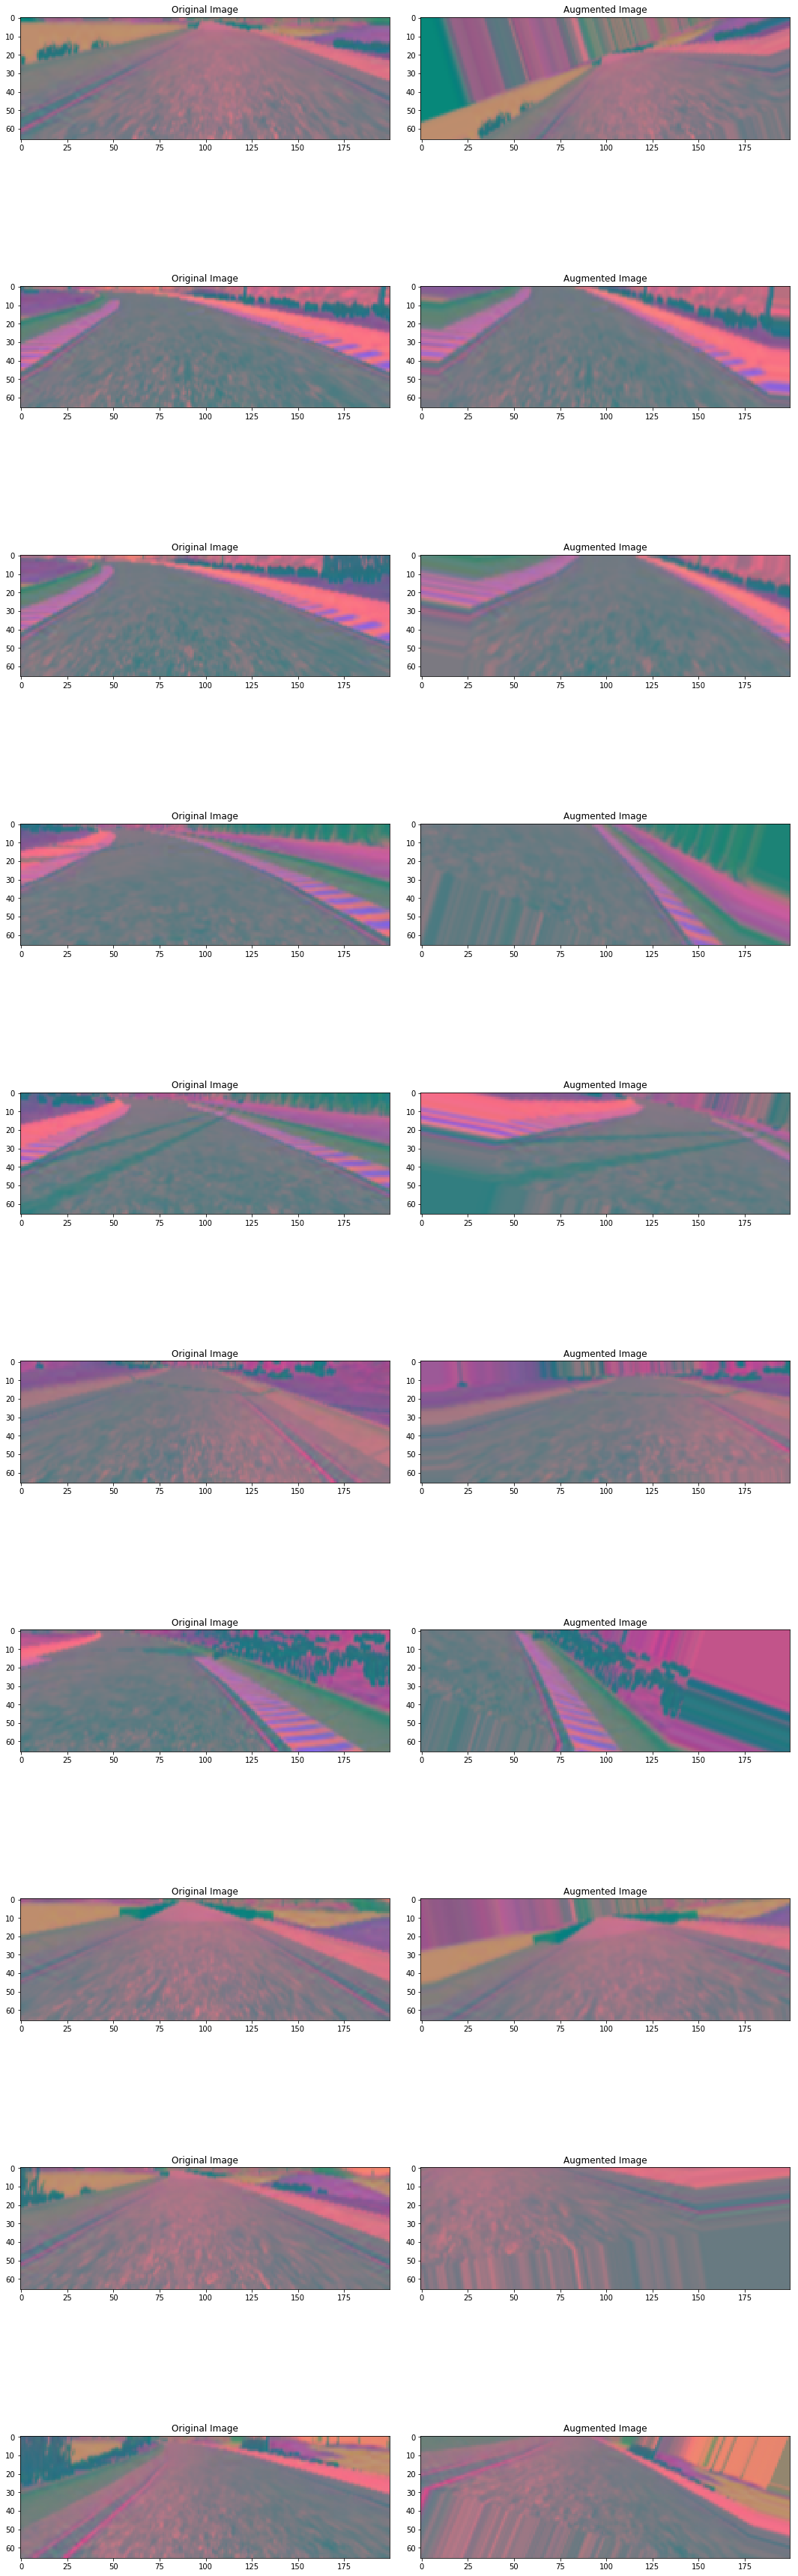

In [22]:
# Viewing more augmented
ncol = 2
nrow = 10

fig,axs = plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0,801)
    random_image = x_train[randnum]
    random_steering = y_train[randnum]
    
    original_image = x_train[randnum]
    augmented_image,steering = random_augment(random_image,random_steering)
    #print(augmented_image - original_image)
    axs[i][0].imshow(original_image)
    axs[i][0].set_title('Original Image')
    
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('Augmented Image') 

In [23]:
#Generate the batch augmented datasets.
def batch_generator(image,steering_ang,batch_size,istraining):
    while True:
        batch_img = []
        batch_steering = []
        for i in range(batch_size):
            random_index = random.randint(0,len(image)-1)
            if istraining:
                im,steering = random_augment(image[random_index],steering_ang[random_index])
            else:
                im = image[random_index]
                steering = steering_ang[random_index]
            #im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img),np.asarray(batch_steering))

# Defining the Nvidia Model & Train the data without augmentation technique.

In [106]:
#Train the data without augmentation.
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24,5,5, subsample=(2,2),input_shape = (66,200,3), activation = 'relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation = 'relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation = 'relu'))
    model.add(Convolution2D(64,3,3, activation = 'relu'))
    model.add(Convolution2D(64,3,3, activation = 'relu'))
    model.add(Dropout(0.5))
    
    
    model.add(Flatten())
    model.add(Dense(100,activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50,activation = 'relu'))
    model.add(Dense(10,activation = 'relu'))
    model.add(Dense(1))
    
    optimizer = Adam(lr = 1e-3)
    model.compile(loss = 'mse', optimizer=optimizer)
    return model

In [107]:
model = nvidia_model()
print(model.summary())

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  """
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Con

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [39]:
history = model.fit(x_train,y_train,epochs=100,validation_data=(x_valid, y_valid),batch_size=100, verbose=1,shuffle=1)

Train on 812 samples, validate on 203 samples
Epoch 1/100
812/812 [==============================] - 11s 13ms/step - loss: 0.1360 - val_loss: 0.1125
Epoch 2/100
812/812 [==============================] - 9s 12ms/step - loss: 0.1332 - val_loss: 0.1266
Epoch 3/100
812/812 [==============================] - 10s 12ms/step - loss: 0.1426 - val_loss: 0.1218
Epoch 4/100
812/812 [==============================] - 10s 12ms/step - loss: 0.1264 - val_loss: 0.1108
Epoch 5/100
812/812 [==============================] - 10s 13ms/step - loss: 0.1281 - val_loss: 0.1095
Epoch 6/100
812/812 [==============================] - 11s 13ms/step - loss: 0.1286 - val_loss: 0.1114
Epoch 7/100
812/812 [==============================] - 12s 15ms/step - loss: 0.1297 - val_loss: 0.1212
Epoch 8/100
812/812 [==============================] - 11s 14ms/step - loss: 0.1236 - val_loss: 0.1092
Epoch 9/100
812/812 [==============================] - 11s 13ms/step - loss: 0.1176 - val_loss: 0.1090
Epoch 10/100
812/812 [======

Text(0.5, 0, 'Epoch')

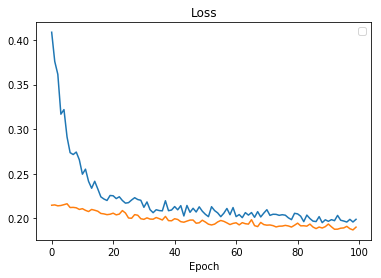

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend('training','validation')
plt.title('Loss')
plt.xlabel('Epoch')

Change a new nvidia model

In [29]:
def new_nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24,5,5, subsample=(2,2),input_shape = (66,200,3), activation = 'elu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation = 'elu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation = 'elu'))
    model.add(Convolution2D(64,3,3, activation = 'elu'))
    
    model.add(Convolution2D(64,3,3, activation = 'elu'))
    model.add(Dropout(0.5))
    
    
    model.add(Flatten())
    
    model.add(Dense(100,activation = 'elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(50,activation = 'elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(10,activation = 'elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    optimizer = Adam(lr = 1e-5)
    model.compile(loss = 'mse', optimizer=optimizer)
    return model

Text(0.5, 0, 'Epoch')

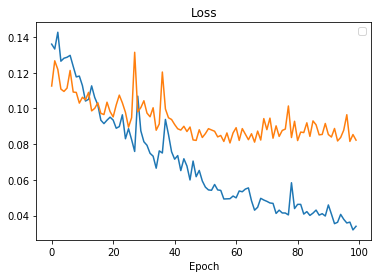

In [40]:
plt.plot(history.history['loss'])  #blue
plt.plot(history.history['val_loss']) #orange
plt.legend('training','validation')
plt.title('Loss')
plt.xlabel('Epoch')

# Train the data with Augmentation Technique.

In [24]:
#Train the data without augmentation.
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24,5,5, subsample=(2,2),input_shape = (66,200,3), activation = 'relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation = 'relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation = 'relu'))
    model.add(Convolution2D(64,3,3, activation = 'relu'))
    model.add(Convolution2D(64,3,3, activation = 'relu'))
    #model.add(Dropout(0.5))
    
    
    model.add(Flatten())
    model.add(Dense(100,activation = 'relu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(50,activation = 'relu'))
    model.add(Dense(10,activation = 'relu'))
    model.add(Dense(1))
    
    optimizer = Adam(lr = 1e-3)
    model.compile(loss = 'mse', optimizer=optimizer)
    return model

In [25]:
model = nvidia_model()
print(model.summary())

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  """
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [26]:
history = model.fit_generator(batch_generator(x_train,y_train,100,1),
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=batch_generator(x_valid,y_valid,100,0),
                              validation_steps=128,
                              verbose=1,
                              shuffle=1)

Epoch 1/10
100/100 [==============================] - 257s 3s/step - loss: 0.2121 - val_loss: 0.1977
Epoch 2/10
100/100 [==============================] - 252s 3s/step - loss: 0.2035 - val_loss: 0.1795
Epoch 3/10
100/100 [==============================] - 227s 2s/step - loss: 0.1988 - val_loss: 0.1826
Epoch 4/10
100/100 [==============================] - 224s 2s/step - loss: 0.2006 - val_loss: 0.1730
Epoch 5/10
100/100 [==============================] - 213s 2s/step - loss: 0.1965 - val_loss: 0.1766
Epoch 6/10
100/100 [==============================] - 209s 2s/step - loss: 0.1884 - val_loss: 0.1580
Epoch 7/10
100/100 [==============================] - 200s 2s/step - loss: 0.1805 - val_loss: 0.1494
Epoch 8/10
100/100 [==============================] - 215s 2s/step - loss: 0.1774 - val_loss: 0.1335
Epoch 9/10
100/100 [==============================] - 220s 2s/step - loss: 0.1667 - val_loss: 0.1241
Epoch 10/10
100/100 [==============================] - 202s 2s/step - loss: 0.1596 - val_lo

In [27]:
model.save('aug_model.h5')

C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\legend.py:798: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\legend.py:798: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\legend.py:798: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
C:\Users\dell\Anaconda3\lib\site-p

Text(0.5, 0, 'Epoch')

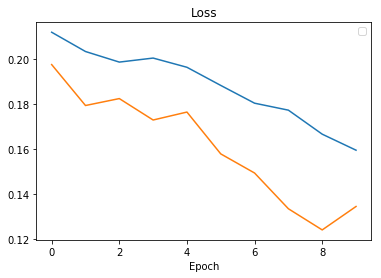

In [28]:
plt.plot(history.history['loss'])  #blue
plt.plot(history.history['val_loss']) #orange
plt.legend('training','validation')
plt.title('Loss')
plt.xlabel('Epoch')